# Reading in file and converting timestamps

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

from datetime import datetime
from dateutil.parser import parse

import math
import os
import copy

In [3]:
# Reading the text file
product_descriptions = pd.read_csv('product_rating_modified.txt', header = None, sep = '\', \'', engine = 'python')

FileNotFoundError: [Errno 2] No such file or directory: 'product_rating_modified.txt'

In [4]:
!pwd

/Users/theocarr/IUPUI/DarkWeb/OldCode


In [3]:
# Function to convert numeric time to datetime object
def parseDate(raw_date, pattern = '%Y%m%d%H%M%S'):
    string_date = str(raw_date)
    return(datetime.strptime(string_date, pattern))

# Parse the dates, and place in new column
product_descriptions['dates'] = product_descriptions.iloc[:,7].apply(parseDate)

# Tokenizing Product Description

In [4]:
import spacy
from spacy.lang.en import English
parser = English()

In [5]:
# Function to tokenize titles
def tokenize_1(title):
    tokens = parser(title.lower())
    tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]
    return(tokens)

In [6]:
# Apply tokenizer to the titles in the dataframe
product_descriptions['tokenized_titles'] = product_descriptions.iloc[:,15].apply(tokenize_1)

In [7]:
# Alternative tokenizer
special_char =['`','\'','=','-','~','!','@','#','$','^','&','*','(',')','_','+','[',']','{','}',';','\\',':','|','<','<','>','?','//']

def remove_special_char(string):
    for char in special_char:
        string = string.replace(char,' ')
    return(string)

def tokenize(string):
    return remove_special_char(string).split()

# Categorize drugs

In [8]:
import drugLookup

Get list of slang phrases that are multiple words

In [9]:
# Load drugs dictionary
drugs_dict = drugLookup.get_drugs_dict()

complete_multi_word_list = []

drug_index = 0
#For loop that gets all the synonyms of drugs with more than one word
for drug in drugs_dict.keys():
    slang_words = drugs_dict[drug]
    multi_word_list = []
    for slang_word in slang_words:
        if ' ' in slang_word:
            multi_word_list.append(slang_word)
    complete_multi_word_list.append(multi_word_list)

In [10]:
# Create multi_word dictionary
drug_cats = list(drugs_dict.keys())
multi_drug_dict = dict(zip(drug_cats, complete_multi_word_list))

In [11]:
# Load dictionary of drugs
drugs_dict = drugLookup.get_drugs_dict()

# Get list of possible drugs for each listing
def categorize_listing(title_set):
#     Function takes in set of two: first entry is raw_title, second is tokenized_title
    possible_drugs = set()
    raw_title = title_set[0]
    tokenized_title = title_set[1]
    for drug in drugs_dict.keys():
        if any(token in drugs_dict[drug] for token in tokenized_title): # uses tokenization
            possible_drugs.add(drug)
        if any(multi_word in raw_title for multi_word in multi_drug_dict[drug]):
            possible_drugs.add(drug)
    return possible_drugs

In [12]:
# Categorize each listing
product_descriptions['drug_prediction'] = product_descriptions.iloc[:,[15,17]].apply(categorize_listing, axis = 1)

# Remove bad dates

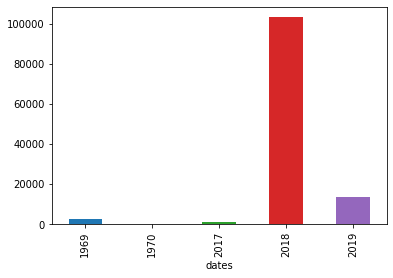

In [13]:
# Look at distribution of dates
product_descriptions['dates'].groupby(product_descriptions["dates"].dt.year).count().plot(kind='bar')
plt.show()

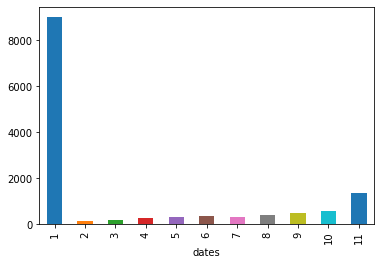

In [14]:
# Plot the 2019 dates
after_2019 = product_descriptions['dates'] > datetime(2019,1,1)
after_2019_df = product_descriptions[after_2019]
after_2019_df['dates'].groupby(after_2019_df["dates"].dt.month).count().plot(kind='bar')
plt.show()

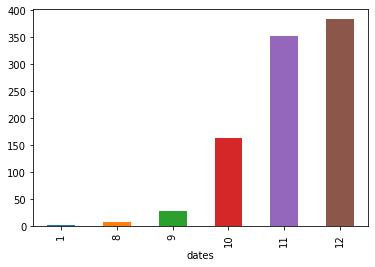

In [15]:
# Plot the 2017 dates
before_2018 = product_descriptions['dates'] < datetime(2018,1,1)
after_2016 = product_descriptions['dates'] > datetime(2016,12,31)
in_2017_df = product_descriptions[after_2016 & before_2018]
in_2017_df['dates'].groupby(in_2017_df["dates"].dt.month).count().plot(kind='bar')
plt.show()

In [16]:
# Filter out the 1969/1970/2019 dates
# good_dates = product_desci
before_2019 = product_descriptions['dates'] < datetime(2019,1,1)
after_2017 = product_descriptions['dates'] > datetime(2017,12,31)
df = product_descriptions[before_2019 & after_2017]

In [17]:
df.head()

0  1     2                3        4    5  \
1  '1099  3  1927  HeinekenExpress  B*****u  5.0   
2  '1100  3  1927  HeinekenExpress  z*****d  5.0   
3  '1101  3  1927  HeinekenExpress  b*****4  5.0   
4  '1102  3  1927  HeinekenExpress  K*****z  5.0   
5  '1103  3  1927  HeinekenExpress  M*****h  5.0   

                                                   6               7    8  \
1                                No feedback comment  20181217000000 -1.0   
2                                       Thank y bro   20181217000000 -1.0   
3  Seems pretty nice, weighed 1g and got a free p...  20181216000000 -1.0   
4  I just now saw your return policy says you don...  20181211000000 -1.0   
5  Slightly overweight - Fast Shipping (7 Days UK...  20181209000000 -1.0   

       9   10  11  12    13           14  \
1  13.06 -1.0  -1  -1  4410  1162_88_173   
2  12.90 -1.0  -1  -1  4410  1162_88_173   
3  12.88 -1.0  -1  -1  4410  1162_88_173   
4  50.44 -1.0  -1  -1  4410  1162_88_173   
5  50.54 -1.0  -1  -1  4410  1162_88_173   

                                                  15      dates  \
1  ? MDMA very high QUALITY 87%?The Best MDMA for... 2018-12-17   
2  ? MDMA very high QUALITY 87%?The Best MDMA for... 2018-12-17   
3  ? MDMA very high QUALITY 87%?The Best MDMA for... 2018-12-16   
4  ? MDMA very high QUALITY 87%?The Best MDMA for... 2018-12-11   
5  ? MDMA very high QUALITY 87%?The Best MDMA for... 2018-12-09   

                                    tokenized_titles drug_prediction  
1  [?, mdma, very, high, quality, 87%?the, best, ...       {ecstasy}  
2  [?, mdma, very, high, quality, 87%?the, best, ...       {ecstasy}  
3  [?, mdma, very, high, quality, 87%?the, best, ...       {ecstasy}  
4  [?, mdma, very, high, quality, 87%?the, best, ...       {ecstasy}  
5  [?, mdma, very, high, quality, 87%?the, best, ...       {ecstasy}

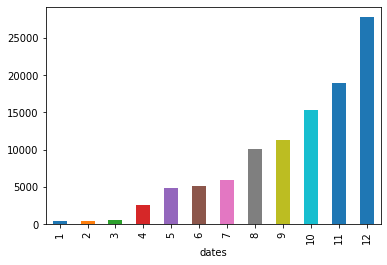

In [17]:
# Plot 2018 dates
df['dates'].groupby(df["dates"].dt.month).count().plot(kind='bar')
plt.show()

# Distribution of sales among vendors

In [42]:
# Get subset of columns that we care about
drug_data = df.iloc[:,[3,15,16,17,18]]
drug_data.columns = ['vendor_name', 'title', 'date','tokenized_title', 'drug_prediction']

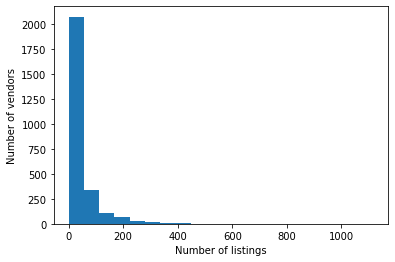

In [43]:
# Count number of listings for each vendor and create histogram
sales_by_vendor = drug_data['vendor_name'].groupby(drug_data['vendor_name']).count()
plt.hist(sales_by_vendor, bins = 20)
plt.xlabel('Number of listings')
plt.ylabel('Number of vendors')
plt.show()


In [44]:
# Sort vendors by number of sales
sorted_sales_by_vendor = sales_by_vendor.sort_values(ascending = False)
at_least_100_sales = np.where(sorted_sales_by_vendor == 100)[0][-1]
at_least_50_sales = np.where(sorted_sales_by_vendor == 50)[0][-1]
at_least_20_sales = np.where(sorted_sales_by_vendor == 20)[0][-1]

In [45]:
# Get cumulative sum of series
cumulative_sales = [np.sum(sorted_sales_by_vendor[:i]) for i in range(len(sorted_sales_by_vendor))]

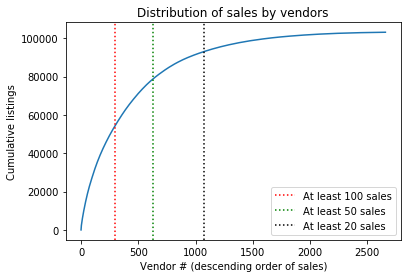

In [46]:
# Plot number of vendors vs. number of listings
plt.plot(cumulative_sales)
plt.axvline(x=at_least_100_sales, color = 'r',linestyle = ':', label = 'At least 100 sales')
plt.axvline(x=at_least_50_sales, color = 'g',linestyle = ':', label = 'At least 50 sales')
plt.axvline(x=at_least_20_sales, color = 'k',linestyle = ':', label = 'At least 20 sales')
plt.xlabel('Vendor # (descending order of sales)')
plt.ylabel('Cumulative listings')
plt.title('Distribution of sales by vendors')
plt.legend()
plt.show()

# Thresholding out low-frequency vendors

In [47]:
# Threshold out vendors with less than given threshold of listings
thresh = 100
hi_freq_vendors = sales_by_vendor[sales_by_vendor > 100]
print('Vendors before thresholding:', len(sales_by_vendor))
print('Vendors after thresholding:', len(hi_freq_vendors))

Vendors before thresholding: 2660
Vendors after thresholding: 286


In [48]:
#Calculate the ratio of listings for vendors > threshold
percentage_of_listings = np.sum(hi_freq_vendors)/np.sum(sales_by_vendor)
percent_of_vendors = len(hi_freq_vendors)/len(sales_by_vendor)
print('Percent of listings:',percentage_of_listings)
print('Percent of vendors :',percent_of_vendors)

Percent of listings: 0.5160599156527219
Percent of vendors : 0.10751879699248121


In [49]:
# Function checks if item is in the set
def isInSet(item, myset):
    return(item in myset)

hi_freq_vendor_names = list(hi_freq_vendors.index)

# For every row, check if the vendor is in high-frequency set
is_hi_freq_row = drug_data['vendor_name'].apply(isInSet, myset = hi_freq_vendors.index)

# Get dataframe with just the high-frequency set
hi_freq_df = drug_data[is_hi_freq_row]

Now analyze distribution for thresholded dataframe

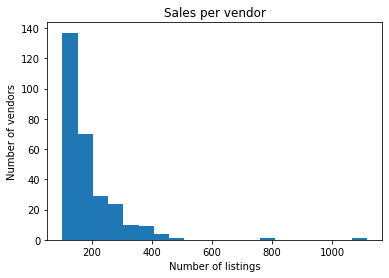

In [50]:
# Count number of listings for each vendor and create histogram
sales_by_vendor = hi_freq_df['vendor_name'].groupby(hi_freq_df['vendor_name']).count()
plt.hist(sales_by_vendor, bins = 20)
plt.xlabel('Number of listings')
plt.ylabel('Number of vendors')
plt.title('Sales per vendor')
plt.show()

Filter out listings with no labels or with multiple labels

In [51]:
# Plot number of categories per listing
print('Count number of categories for each listing:')
print(hi_freq_df['drug_prediction'].apply(len).groupby(hi_freq_df['drug_prediction'].apply(len)).count())

# Get listings with fewer than 1 category
cond1 = hi_freq_df['drug_prediction'].apply(len) < 2
cond2 = hi_freq_df['drug_prediction'].apply(len) > 0
drug_df = copy.deepcopy(hi_freq_df[cond1 & cond2])

Count number of categories for each listing:
drug_prediction
0    52152
2     1077
Name: drug_prediction, dtype: int64


In [52]:
# Function to pop element from a set
# Will be applied to column of dataframe
def mypop(myset):
    return(myset.pop())

temp = copy.deepcopy(drug_df['drug_prediction'])
drug_df['drug_prediction'] = temp.apply(mypop)

# Drug Category analysis

In [53]:
# Plot drug categories by popularity
drug_counts = drug_df['drug_prediction'].groupby(drug_df['drug_prediction']).count().sort_values(ascending = False)

# For each drug, get percentage of the whole
print(round(100 * drug_counts/np.sum(drug_counts),2))

# Plot results
drug_counts.plot(kind = 'bar')
plt.ylabel('frequency')
plt.title('drug frequencies')
plt.show()

Series([], Name: drug_prediction, dtype: float64)


TypeError: Empty 'DataFrame': no numeric data to plot

In [35]:
# Remove all non-drug listings
drug_rows = drug_df['drug_prediction'] != 'not_drugs'
drug_df = drug_df[drug_rows]

drug_prediction
marijuana          16.60
cocaine            13.85
benzodiazepines    13.43
ecstasy             8.63
methamphetamine     7.45
heroin              6.44
ketamine            5.70
lsd                 4.89
others              4.72
hashish             4.08
psilocybin          3.75
dmt                 2.58
amphetamine         1.62
buprenorphine       1.50
oxycodone           1.49
methadone           1.09
two_cb              0.59
inhalants           0.54
methylphenidate     0.52
codeine             0.15
morphine            0.14
fentanyl            0.11
oxymorphone         0.07
khat                0.04
mescaline           0.01
Name: drug_prediction, dtype: float64


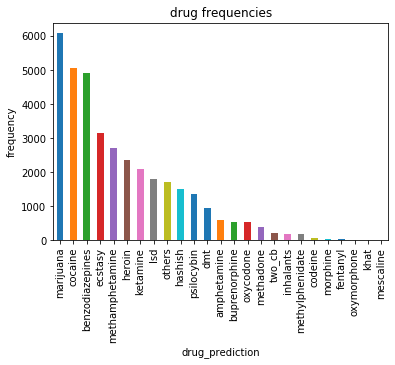

In [36]:
# Plot drug categories by popularity
drug_counts = drug_df['drug_prediction'].groupby(drug_df['drug_prediction']).count().sort_values(ascending = False)

# For each drug, get percentage of the whole
print(round(100 * drug_counts/np.sum(drug_counts),2))

# Plot results
drug_counts.plot(kind = 'bar')
plt.ylabel('frequency')
plt.title('drug frequencies')
plt.show()

Plot number of drugs sold per vendor (histogram)

In [37]:
# Get list of vendors in dataframe
_ , vendor_list = pd.factorize(drug_df['vendor_name'])

# Function to count number of drugs per vendor
def countDrugsForVendor(vendor_name):
    return(len(drug_df[drug_df['vendor_name'] == vendor_name].groupby('drug_prediction').count().index))

# Get number of drugs sold for each vendor
vendor_drug_counts = {vendor : countDrugsForVendor(vendor) for vendor in vendor_list}

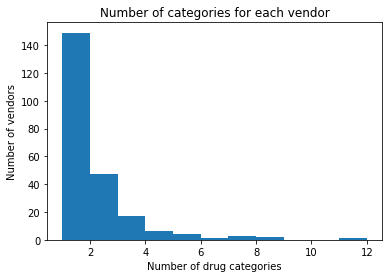

In [38]:
# Make histogram of vendor_drug_counts
bins = range(1,max(vendor_drug_counts.values()))
plt.hist(vendor_drug_counts.values(), bins = bins)
plt.xlabel('Number of drug categories')
plt.ylabel('Number of vendors')
plt.title('Number of categories for each vendor')
plt.show()

# Purity / Quantity extraction

In [38]:
import re

In [21]:
a = 'hello/world-\\credits$$cards***'
re.split(r'[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', a)

['hello', 'world', '', 'credits', '', 'cards', '', '', '']

In [178]:
title = "? MDMA very high QUALITY 87%?The Best MDMA for the Cheapest Price?‚Ç¨3.50','? Speed High Quality 72%?BULK PRICES?‚Ç¨ 1.30?','?LSD Anonymous Mask 220ug ?BULK PRICES?‚Ç¨2.75','[LSD] 5x 250ug+- Maya white fluff tabs + FREE SHIP + ESCROW + TOP QUALITY','NN-DMT The Spirit Molecule 1gram Dream Sand','?HANDS DOWN! ! !? 7$ ONLY FOR 2 PURE LSD TABS 200mcg EACH! NL LABS!?FREE WW 2-4D XPRESS SHIPPI','1GR PURE HEROIN!! FIRST HAND QUALITY ROCKS!','?FREE SAMPLE? CRAZY INTRO OFFER? 2 x 200ug PURE LSD ACID BLOTTER NL MADE?pay only shippi',' N,N--DMT crystals .25grams','1/2 ozMaster Kush! New Vendor Special','1. Gram Of the Shard','XANAX ALPRAZOLAM 2mg/tab 90 tabs FARMAPRAM','1GR PURE UNCUT COCAINE! PURE COKE BEST OF DARK NET!','? Maya LSD 180ug ?BULK PRICES ?‚Ç¨2.5 ?"

tokens = (parser(title.lower()))
tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]
# print(tokens)
tokenize(title)

['MDMA',
 'very',
 'high',
 'QUALITY',
 '87%',
 'The',
 'Best',
 'MDMA',
 'for',
 'the',
 'Cheapest',
 'Price',
 '‚Ç¨3.50',
 ',',
 'Speed',
 'High',
 'Quality',
 '72%',
 'BULK',
 'PRICES',
 '‚Ç¨',
 '1.30',
 ',',
 'LSD',
 'Anonymous',
 'Mask',
 '220ug',
 'BULK',
 'PRICES',
 '‚Ç¨2.75',
 ',',
 'LSD',
 '5x',
 '250ug',
 'Maya',
 'white',
 'fluff',
 'tabs',
 'FREE',
 'SHIP',
 'ESCROW',
 'TOP',
 'QUALITY',
 ',',
 'NN',
 'DMT',
 'The',
 'Spirit',
 'Molecule',
 '1gram',
 'Dream',
 'Sand',
 ',',
 'HANDS',
 'DOWN',
 '7',
 'ONLY',
 'FOR',
 '2',
 'PURE',
 'LSD',
 'TABS',
 '200mcg',
 'EACH',
 'NL',
 'LABS',
 'FREE',
 'WW',
 '2',
 '4D',
 'XPRESS',
 'SHIPPI',
 ',',
 '1GR',
 'PURE',
 'HEROIN',
 'FIRST',
 'HAND',
 'QUALITY',
 'ROCKS',
 ',',
 'FREE',
 'SAMPLE',
 'CRAZY',
 'INTRO',
 'OFFER',
 '2',
 'x',
 '200ug',
 'PURE',
 'LSD',
 'ACID',
 'BLOTTER',
 'NL',
 'MADE',
 'pay',
 'only',
 'shippi',
 ',',
 'N,N',
 'DMT',
 'crystals',
 '.25grams',
 ',',
 '1',
 '2',
 'ozMaster',
 'Kush',
 'New',
 'Vendor',
 'Spec

In [39]:
import re
match = re.match(r"([0-9,.]+)([a-z,%]+)", '87.5mcg', re.I)
if match is not None:
    print([match.group(1),match.group(2)])

sent = "? MDMA very high QUALITY 87%?The Best MDMA for the Cheapest Price?‚Ç¨3.50','? Speed High Quality 72%?BULK PRICES?‚Ç¨ 1.30?','?LSD Anonymous Mask 220ug ?BULK PRICES?‚Ç¨2.75','[LSD] 5x 250ug+- Maya white fluff tabs + FREE SHIP + ESCROW + TOP QUALITY','NN-DMT The Spirit Molecule 1gram Dream Sand','?HANDS DOWN! ! !? 7$ ONLY FOR 2 PURE LSD TABS 200mcg EACH! NL LABS!?FREE WW 2-4D XPRESS SHIPPI','1GR PURE HEROIN!! FIRST HAND QUALITY ROCKS!','?FREE SAMPLE? CRAZY INTRO OFFER? 2 x 200ug PURE LSD ACID BLOTTER NL MADE?pay only shippi',' N,N--DMT crystals .25grams','1/2 ozMaster Kush! New Vendor Special','1. Gram Of the Shard','XANAX ALPRAZOLAM 2mg/tab 90 tabs FARMAPRAM','1GR PURE UNCUT COCAINE! PURE COKE BEST OF DARK NET!','? Maya LSD 180ug ?BULK PRICES ?‚Ç¨2.5 ?"

tokenized_sent = tokenize(sent)
# print(tokenized_sent)

new_tokens = []
for token in tokenized_sent:
    match = re.match(r"([0-9,.]+)([a-z,%]+)", token, re.I)
    if match is not None:
        temp = [match.group(1),match.group(2)]
        new_tokens += temp
    else:
        new_tokens.append(token)
print(new_tokens)

['87.5', 'mcg']
['MDMA', 'very', 'high', 'QUALITY', '87', '%', 'The', 'Best', 'MDMA', 'for', 'the', 'Cheapest', 'Price', '‚Ç¨3.50', ',', 'Speed', 'High', 'Quality', '72', '%', 'BULK', 'PRICES', '‚Ç¨', '1.30', ',', 'LSD', 'Anonymous', 'Mask', '220', 'ug', 'BULK', 'PRICES', '‚Ç¨2.75', ',', 'LSD', '5', 'x', '250', 'ug', 'Maya', 'white', 'fluff', 'tabs', 'FREE', 'SHIP', 'ESCROW', 'TOP', 'QUALITY', ',', 'NN', 'DMT', 'The', 'Spirit', 'Molecule', '1', 'gram', 'Dream', 'Sand', ',', 'HANDS', 'DOWN', '7', 'ONLY', 'FOR', '2', 'PURE', 'LSD', 'TABS', '200', 'mcg', 'EACH', 'NL', 'LABS', 'FREE', 'WW', '2', '4', 'D', 'XPRESS', 'SHIPPI', ',', '1', 'GR', 'PURE', 'HEROIN', 'FIRST', 'HAND', 'QUALITY', 'ROCKS', ',', 'FREE', 'SAMPLE', 'CRAZY', 'INTRO', 'OFFER', '2', 'x', '200', 'ug', 'PURE', 'LSD', 'ACID', 'BLOTTER', 'NL', 'MADE', 'pay', 'only', 'shippi', ',', 'N,N', 'DMT', 'crystals', '.25', 'grams', ',', '1/2', 'ozMaster', 'Kush', 'New', 'Vendor', 'Special', ',', '1.', 'Gram', 'Of', 'the', 'Shard', ',', '

In [76]:
import re

# Special characters to be removed
special_char =['`','\'','=','-','~','!','@','#','$','^','&','*','(',')','_','+','[',']','{','}',';','\\',':','|','<','<','>','?','//']

# Function to remove special characters
def remove_special_char(string):
    for char in special_char:
        string = string.replace(char,' ')
    return(string)

# Tokenize the title (including measurements)
def tokenize(string):
    # First remove special characters and split words
    old_tokens = remove_special_char(string.lower()).split()
    new_tokens = [] # list to hold refined tokens
    for token in old_tokens:
        match = re.match(r"([0-9,.]+)([a-z,%]+)", token, re.I) # look for measurements
        if match is not None: # if there is a match
            temp = [match.group(1),match.group(2)] # get the groups
            new_tokens += temp # add to the list of new tokens
        else:
            new_tokens.append(token) # otherwise keep the old token
    return(new_tokens)

# Get purity
purity_metrics = ['%','percent']
def getPurity(tokenized_title):
    prev = '' # initialize previous token
    purity = '' # initialize quantity
    for token in tokenized_title:
        if token in purity_metrics:
            purity = prev+token # assume previous token is quantity
        prev = token
    return purity

# Get quantity
quantity_metrics = ['kg','g','g.','mg','mcg','ug','oz','lb', 'gram', 'gr','gr.', 'grams','pound','kilogram','ml']
def getQuantity(tokenized_title):
    prev = '' # initialize previous token
    quantity = '' # initialize quantity
    for token in tokenized_title:
        if token in quantity_metrics:
            quantity = prev+token # assume previous token is quantity
        prev = token
    return quantity

In [70]:
token = '7Grame'
# pattern = re.compile(r"([0-9.]+)([a-z%]+)")
match = re.match(r"([0-9,.]+)([a-z,%]+)", token, re.I)
# match = re.search(pattern, token, re.I) # look for measurements
if match is not None: # if there is a match
    print([match.group(1),match.group(2)]) # get the groups

['7', 'Grame']


In [77]:
tokenize('7gram')

['7', 'gram']

In [5]:
word = 'hiLSDABD there'
# match = re.search(r'([a-z]+)([A-Z]+)', word, re.I)
# if match is not None:
#     print(match.groups())

In [6]:
print(word)
print(tokenize(word))

hiLSDABD there
['hiLSDABD', 'there']


In [111]:
word = '20 OzYes'
pattern = re.compile(r'([^(.*?)a-z]+)([A-Z]+)')
match = re.search(pattern,word)
if match is not None:
    print(match.groups())
# re.split(pattern,word)

('20 ', 'O')


In [81]:
tokenize(' N,N--DMT crystals - 0.5 grams')

['n,n', 'dmt', 'crystals', '0.5', 'grams']

In [79]:
hi_freq_vendor_listings['tokenized_titles'] = hi_freq_vendor_listings['description'].apply(tokenize)
hi_freq_vendor_listings['quantity'] = hi_freq_vendor_listings['tokenized_titles'].apply(getQuantity)
hi_freq_vendor_listings['purity'] = hi_freq_vendor_listings['tokenized_titles'].apply(getPurity)

In [80]:
hi_freq_vendor_listings.to_csv('updated_file.csv')

In [48]:
string = 'WARLOCK - 3,5 Gram - HIGH QUALITY'
remove_special_char(string.lower()).split()
re.match(r"([0-9,.]+)([a-z%]+)", '3,5mg', re.I).groups()
tokenize('1/4 .Oz Shards')

['1/4', '.', 'oz', 'shards']

In [182]:
# check if a string is a number (from stackoverflow)
def is_number(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

# Function to check for quantity
metrics = ['kg','g','mg','ug','oz','lb', 'gram', 'gr', 'grams']
def getQuantity(title):
    tokens = (parser(title.lower()))
    tokenized_title = [token.orth_ for token in tokens if not token.orth_.isspace()]
    prev = '' # initialize previous token
    quantity = '' # initialize quantity
    for token in tokenized_title:
        if token in metrics:
            quantity = prev+token # assume previous token is quantity
        prev = token
    return quantity

purity_metrics = ['%','percent']
def getPurity(title):
    tokens = (parser(title.lower()))
    tokenized_title = [token.orth_ for token in tokens if not token.orth_.isspace()]
    prev = '' # initialize previous token
    quantity = '' # initialize quantity
    for token in tokenized_title:
        if token in purity_metrics:
            quantity = prev+token # assume previous token is quantity
        prev = token
    return quantity

# Function to check for purity
title = '10 gr Purple Kush / Haze quality=B+ (Outdoor & Organic)'
tokens = (parser(title.lower()))
tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]

getQuantity(title)

'10gr'

In [63]:
hi_freq_vendor_listings['quantity'] = hi_freq_vendor_listings['description'].apply(getQuantity)
hi_freq_vendor_listings['purity'] = hi_freq_vendor_listings['description'].apply(getPurity)

In [64]:
hi_freq_vendor_listings.to_csv(path_or_buf = 'quantity_labeling_test.csv')

['warlock', '3', ',', 'gram', 'high', 'quality']

In [10]:
description = "Amazing Crystal Meth *0.3g* WE BEAT ANY PRICE"

# Function to check for purity
tokens = (parser(description.lower()))
tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]

title = [tokens, description]

tokenized_title = title[0] # Get tokenized title
non_tokenized_title = title[1].lower() # get non-tokenized title
possible_drugs = [] # empty list to hold drug predictions
drug_index = 0
for drug in drugs_dict.keys(): # for every drug category
    if any(token in drugs_dict[drug] for token in tokenized_title): # uses tokenization
        print('token',drug)
        possible_drugs.append(drug)
    if any(multi_word in non_tokenized_title for multi_word in multi_drug_dict[drug]):
        print('multi_word',drug)
        possible_drugs.append(drug)
print(possible_drugs)

token cocaine
token methamphetamine
['cocaine', 'methamphetamine']


In [47]:
import drugLookup


In [48]:
#print drugLookup.get_drugs_dict()

In [49]:
# Load drugs dictionary
drugs_dict = drugLookup.get_drugs_dict()

complete_multi_word_list = []

drug_index = 0
#For loop that gets all the synonyms of drugs with more than one word
for drug in drugs_dict.keys():
    slang_words = drugs_dict[drug]
    multi_word_list = []
    for slang_word in slang_words:
        if ' ' in slang_word:
            multi_word_list.append(slang_word)
    complete_multi_word_list.append(multi_word_list)
         
#complete_multi_word_list

# Create multi_word dictionary
drug_cats = list(drugs_dict.keys())
multi_drug_dict = dict(zip(drug_cats, complete_multi_word_list))

In [23]:
test_titles = ['? MDMA very high QUALITY 87%?The Best MDMA for the Cheapest Price?‚Ç¨3.50',
'? Speed High Quality 72%?BULK PRICES?‚Ç¨ 1.30?',
'?LSD Anonymous Mask 220ug ?BULK PRICES?‚Ç¨2.75',
'[LSD] 5x 250ug+- Maya white fluff tabs + FREE SHIP + ESCROW + TOP QUALITY',
'NN-DMT The Spirit Molecule 1gram Dream Sand',
'?HANDS DOWN! ! !? 7$ ONLY FOR 2 PURE LSD TABS 200mcg EACH! NL LABS!?FREE WW 2-4D XPRESS SHIPPI',
'1GR PURE HEROIN!! FIRST HAND QUALITY ROCKS!',
'?FREE SAMPLE? CRAZY INTRO OFFER? 2 x 200ug PURE LSD ACID BLOTTER NL MADE?pay only shippi',
' N,N--DMT crystals .25grams',
'1/2 ozMaster Kush! New Vendor Special',
'1. Gram Of the Shard',
'XANAX ALPRAZOLAM 2mg/tab 90 tabs FARMAPRAM',
'1GR PURE UNCUT COCAINE! PURE COKE BEST OF DARK NET!',
'? Maya LSD 180ug ?BULK PRICES ?‚Ç¨2.5 ?']
test_df = pd.DataFrame(test_titles)

In [24]:
test_df.columns = ['title']

In [37]:
def parse_titles(title):
    tokens = parser(title.lower())
    tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]
    return(tokens)

import re

metrics = ['kg ','g ','mg ','ug ','oz ','lb ', 'gram ', 'gr ', 'grams ','mcg ']

def parse_titles2(title):
    quantity = []
    for metric in metrics:
        match_index = title.find(metric)
        quantity.append(title[match_index-4:match_index+len(metric)-1])
    return(quantity)


def parse_titles3(title):
    return title[title.find('%')-2:title.find('%')+1]

In [0]:
'Pure 100 oz'

In [38]:
test_df['parse1'] = test_df['title'].apply(parse_titles2)
test_df['parse2'] = test_df['title'].apply(parse_titles3)

In [39]:
test_df.to_csv('parsing.csv')

In [16]:
myString = '? Speed High Quality 72?BULK PRICES?‚Ç¨ 1.30?'
myString[myString.find('%')-2:myString.find('%')+1]

''

In [52]:
test_df['parse3'] = test_df['parse1'].apply(max,key = len)

In [54]:
test_df.to_csv('parsing_test.csv')

In [43]:
l = ['a','bb','c']
max(l, key=len)

'bb'

In [50]:
myString = 'john is looking for you'
myString.replace(["is",'looking'], "was")

TypeError: replace() argument 1 must be str, not list

In [134]:
special_char =['`','\'','=','-','~','!','@','#','$','^','&','*','(',')','_','+','[',']','{','}',';','\\',':','|','<','<','>','?','/']

In [124]:
title = "? MDMA very high QUALITY 87%?The Best MDMA for the Cheapest Price?‚Ç¨3.50 10"
def remove_special_char(string):
    for char in special_char:
        string = string.replace(char,' ')
    return(string)

In [174]:
word = '?HANDS DOWN! ! !? 7$ ONLY 3.5 gr kush//indoor*** F*OR 2 PURE 2C-B LSD TABS 200mcg EACH 90% purity! NL LABS!?FREE WW 2-4D XPRESS SHIPPI'
new = remove_special_char(test_title1)
print(new.split())

['MDMA', 'very', 'high', 'QUALITY', '87%', 'The', 'Best', 'MDMA', 'for', 'the', 'Cheapest', 'Price', '‚Ç¨3.50', ',', 'Speed', 'High', 'Quality', '72%', 'BULK', 'PRICES', '‚Ç¨', '1.30', ',', 'LSD', 'Anonymous', 'Mask', '220ug', 'BULK', 'PRICES', '‚Ç¨2.75', ',', 'LSD', '5x', '250ug', 'Maya', 'white', 'fluff', 'tabs', 'FREE', 'SHIP', 'ESCROW', 'TOP', 'QUALITY', ',', 'NN', 'DMT', 'The', 'Spirit', 'Molecule', '1gram', 'Dream', 'Sand', ',', 'HANDS', 'DOWN', '7', 'ONLY', 'FOR', '2', 'PURE', 'LSD', 'TABS', '200mcg', 'EACH', 'NL', 'LABS', 'FREE', 'WW', '2', '4D', 'XPRESS', 'SHIPPI', ',', '1GR', 'PURE', 'HEROIN', 'FIRST', 'HAND', 'QUALITY', 'ROCKS', ',', 'FREE', 'SAMPLE', 'CRAZY', 'INTRO', 'OFFER', '2', 'x', '200ug', 'PURE', 'LSD', 'ACID', 'BLOTTER', 'NL', 'MADE', 'pay', 'only', 'shippi', ',', 'N,N', 'DMT', 'crystals', '.25grams', ',', '1', '2', 'ozMaster', 'Kush', 'New', 'Vendor', 'Special', ',', '1.', 'Gram', 'Of', 'the', 'Shard', ',', 'XANAX', 'ALPRAZOLAM', '2mg', 'tab', '90', 'tabs', 'FARMAP

In [164]:
test_title1 = "? MDMA very high QUALITY 87%?The Best MDMA for the Cheapest Price?‚Ç¨3.50','? Speed High Quality 72%?BULK PRICES?‚Ç¨ 1.30?','?LSD Anonymous Mask 220ug ?BULK PRICES?‚Ç¨2.75','[LSD] 5x 250ug+- Maya white fluff tabs + FREE SHIP + ESCROW + TOP QUALITY','NN-DMT The Spirit Molecule 1gram Dream Sand','?HANDS DOWN! ! !? 7$ ONLY FOR 2 PURE LSD TABS 200mcg EACH! NL LABS!?FREE WW 2-4D XPRESS SHIPPI','1GR PURE HEROIN!! FIRST HAND QUALITY ROCKS!','?FREE SAMPLE? CRAZY INTRO OFFER? 2 x 200ug PURE LSD ACID BLOTTER NL MADE?pay only shippi',' N,N--DMT crystals .25grams','1/2 ozMaster Kush! New Vendor Special','1. Gram Of the Shard','XANAX ALPRAZOLAM 2mg/tab 90 tabs FARMAPRAM','1GR PURE UNCUT COCAINE! PURE COKE BEST OF DARK NET!','? Maya LSD 180ug ?BULK PRICES ?‚Ç¨2.5 ?"


In [165]:

# Function to extract all the numbers from the given string 
def getNumbers(str): 
    digits = re.findall(r'[0-9]+', str) 
#     digits_index = re.
    return digits

array_of_numbers = getNumbers(test_title1) 

print (array_of_numbers)




['87', '3', '50', '72', '1', '30', '220', '2', '75', '5', '250', '1', '7', '2', '200', '2', '4', '1', '2', '200', '25', '1', '2', '1', '2', '90', '1', '180', '2', '5']


In [173]:
[s for s in test_title1.split() if s.isdigit()]

['2', '2', '90']

In [56]:
tokens = parser('2C-B')
tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]

In [57]:
tokens

['2C', '-', 'B']

# Probability Distribution

In [0]:
hi_freq_vendor_listings['vendor_name']